**Audio Engagement Project EDA**
--

**Structure**
--
1. Overview
2. Data Collection
3. Descriptive Statistics
4. Data Visualization and Correlation Analysis
5. Feature Scaling
6. Data Visualization
7. General Observations and Summary

**1. Overview**
--

The goal is to predict how long a user will listen to an audio episode, based on a range of feature data describing both the listener and the audio content.

The dataset was synthetically generated based on real-world user audio consumption patterns. Feature distributions are realistic but not identical to any publicly available dataset.

**train.csv** - the training dataset; `Listening_Time_minutes` is the target variable

**test.csv** - the test dataset; your objective is to predict the `Listening_Time_minutes` for each row

**sample_submission.csv** - a sample submission file in the correct format.

**2. Data Collection**
--

**Import Data and Required Packages**

In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle
import os
import zipfile
import time
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.preprocessing import RobustScaler
import statistics

**Import the DataSet**

In [178]:
kaggle.api.authenticate()
kaggle.api.competition_download_files('audio-engagement-challenge', path='data')

In [179]:
path_to_zip_file = "data/audio-engagement-challenge.zip"
dir_to_extract="data/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(dir_to_extract)

**File information**

In [180]:
print(kaggle.api.competition_list_files('audio-engagement-challenge').files)

[{"ref": "", "name": "sample_submission.csv", "description": "", "totalBytes": 3500026, "url": "", "creationDate": "2025-10-11T12:36:50.840Z"}, {"ref": "", "name": "test.csv", "description": "", "totalBytes": 21277250, "url": "", "creationDate": "2025-10-11T12:36:50.840Z"}, {"ref": "", "name": "train.csv", "description": "", "totalBytes": 70036578, "url": "", "creationDate": "2025-10-11T12:36:50.840Z"}]


**Import the CSV Data as Pandas DataFrame**

In [181]:
start = time.time()
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")
print("Files loaded in", time.time()-start, "seconds")

Files loaded in 1.880692958831787 seconds


**3. Descriptive Statistics**
--

In [182]:
print("Shape of the training dataset:", train.shape)
print("Shape of the testing dataset:", test.shape)
print("Shape of the sample submission dataset:", sample_submission.shape)

Shape of the training dataset: (750000, 12)
Shape of the testing dataset: (250000, 11)
Shape of the sample submission dataset: (250000, 2)


In [183]:
print("Range of indexes of the training dataset:", train.index)
print("Range of indexes of the testing dataset:", test.index)
print("Range of indexes of the sample submission dataset:", sample_submission.index)

Range of indexes of the training dataset: RangeIndex(start=0, stop=750000, step=1)
Range of indexes of the testing dataset: RangeIndex(start=0, stop=250000, step=1)
Range of indexes of the sample submission dataset: RangeIndex(start=0, stop=250000, step=1)


In [184]:
print("Columns of the training dataset:",train.columns)
print("Columns of the testing dataset:",test.columns)
print("Columns of the sample submission dataset:",sample_submission.columns)

Columns of the training dataset: Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment', 'Listening_Time_minutes'],
      dtype='object')
Columns of the testing dataset: Index(['id', 'Podcast_Name', 'Episode_Title', 'Episode_Length_minutes',
       'Genre', 'Host_Popularity_percentage', 'Publication_Day',
       'Publication_Time', 'Guest_Popularity_percentage', 'Number_of_Ads',
       'Episode_Sentiment'],
      dtype='object')
Columns of the sample submission dataset: Index(['id', 'Listening_Time_minutes'], dtype='object')


In [185]:
train.info()
test.info()
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


**Show top 5 records**

In [186]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [187]:
test.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


In [188]:
sample_submission.head()

,id,Listening_Time_minutes
0,750000,45.437
1,750001,45.437
2,750002,45.437
3,750003,45.437
4,750004,45.437


**Show 5 last records**

In [189]:
train.tail()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
749995,749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000
749998,749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.72939
749999,749999,Sports Central,Episode 99,24.10,Sports,22.45,Saturday,Night,36.72,0.0,Neutral,11.94439


In [190]:
test.tail()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
249995,999995,Mind & Body,Episode 100,21.05,Health,65.77,Saturday,Evening,96.40,3.0,Negative
249996,999996,Joke Junction,Episode 85,85.50,Comedy,41.47,Saturday,Night,30.52,2.0,Negative
249997,999997,Joke Junction,Episode 63,12.11,Comedy,25.92,Thursday,Evening,73.69,1.0,Neutral
249998,999998,Market Masters,Episode 46,113.46,Business,43.47,Friday,Night,93.59,3.0,Positive
249999,999999,Brain Boost,Episode 46,78.05,Education,41.72,Friday,Morning,50.77,0.0,Negative


In [191]:
sample_submission.tail()

,id,Listening_Time_minutes
249995,999995,45.437
249996,999996,45.437
249997,999997,45.437
249998,999998,45.437
249999,999999,45.437


**Check duplicates**

In [192]:
print("Duplicates for the training dataset:",train.duplicated().sum())
print("Duplicates for the testing dataset:",test.duplicated().sum())
print("Duplicates for the training dataset:",train.duplicated().sum())

Duplicates for the training dataset: 0
Duplicates for the testing dataset: 0
Duplicates for the training dataset: 0


**There are no duplicates**

**Check data types**

In [193]:
train.dtypes

id                               int64
Podcast_Name                    object
Episode_Title                   object
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Publication_Day                 object
Publication_Time                object
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
Listening_Time_minutes         float64
dtype: object

In [194]:
test.dtypes

id                               int64
Podcast_Name                    object
Episode_Title                   object
Episode_Length_minutes         float64
Genre                           object
Host_Popularity_percentage     float64
Publication_Day                 object
Publication_Time                object
Guest_Popularity_percentage    float64
Number_of_Ads                  float64
Episode_Sentiment               object
dtype: object

In [195]:
sample_submission.dtypes

id                          int64
Listening_Time_minutes    float64
dtype: object

**Check unique values**

In [196]:
train.nunique()

id                             750000
Podcast_Name                       48
Episode_Title                     100
Episode_Length_minutes          12268
Genre                              10
Host_Popularity_percentage       8038
Publication_Day                     7
Publication_Time                    4
Guest_Popularity_percentage     10019
Number_of_Ads                      12
Episode_Sentiment                   3
Listening_Time_minutes          42807
dtype: int64

In [197]:
test.nunique()

id                             250000
Podcast_Name                       48
Episode_Title                     100
Episode_Length_minutes          11631
Genre                              10
Host_Popularity_percentage       8010
Publication_Day                     7
Publication_Time                    4
Guest_Popularity_percentage      9961
Number_of_Ads                       6
Episode_Sentiment                   3
dtype: int64

In [198]:
sample_submission.nunique()

id                        250000
Listening_Time_minutes         1
dtype: int64

In [199]:
print("Unique value:", sample_submission['Listening_Time_minutes'].unique())

Unique value: [45.437]


In [200]:
num_features = [feature for feature in train.columns if train[feature].dtype != 'O']
cat_features = [feature for feature in train.columns if train[feature].dtype == 'O']
print('We have {} numerical features:{}'.format(len(num_features), num_features))
print('We have {} categorical features:{}'.format(len(cat_features), cat_features))
for cat in cat_features:
    print('Number of categories for {}: {}'.format(cat, len(train[cat].unique())))

We have 6 numerical features:['id', 'Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads', 'Listening_Time_minutes']
We have 6 categorical features:['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
Number of categories for Podcast_Name: 48
Number of categories for Episode_Title: 100
Number of categories for Genre: 10
Number of categories for Publication_Day: 7
Number of categories for Publication_Time: 4
Number of categories for Episode_Sentiment: 3


In [201]:
num_features = [feature for feature in test.columns if test[feature].dtype != 'O']
cat_features = [feature for feature in test.columns if test[feature].dtype == 'O']
print('We have {} numerical features:{}'.format(len(num_features), num_features))
print('We have {} categorical features:{}'.format(len(cat_features), cat_features))
for cat in cat_features:
    print('Number of categories for {}: {}'.format(cat, len(test[cat].unique())))

We have 5 numerical features:['id', 'Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']
We have 6 categorical features:['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
Number of categories for Podcast_Name: 48
Number of categories for Episode_Title: 100
Number of categories for Genre: 10
Number of categories for Publication_Day: 7
Number of categories for Publication_Time: 4
Number of categories for Episode_Sentiment: 3


**Check missing values**

In [202]:
train.isna().sum()

id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

**There are missing values in `Episode_Length_minutes`(11.6% of training data), `Guest_Popularity_percentage`(19.5% of training data) and `Number_of_Ads`(1 record) columns**

In [203]:
test.isna().sum()

id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64

**There are missing values in `Episode_Length_minutes`(11.5% of testing data) and `Guest_Popularity_percentage`(19.5% of testing data) columns**

In [204]:
sample_submission.isna().sum()

id                        0
Listening_Time_minutes    0
dtype: int64

**There is no missing values**

**Replace missing value in `Number_of_Ads` column with median**

In [205]:
train['Number_of_Ads']=train['Number_of_Ads'].fillna(train['Number_of_Ads'].median())
train['Number_of_Ads'].isna().sum()

np.int64(0)

**Replace missing values in `Episode_Length_minutes` and `Guest_Popularity_percentage` by Imputer**

In [206]:
train_imp = train[num_features].drop(columns=['id'])
test_imp = test[num_features].drop(columns=['id'])

In [207]:
def add_missing(data, frac=0.2):
    data_missing = data.copy()
    mask = np.random.rand(*data.shape)<frac
    data_missing[mask] = np.nan
    return data_missing, mask

def impute_data(data_train, data_test, sample_size=50000, chunk_size=50000):
    np.random.seed(42)
    sample_idx = np.random.choice(len(data_train), size=sample_size, replace=False)
    X_sample = data_train.iloc[sample_idx]
    
    imputers = {
        'Simple': SimpleImputer(strategy='median'),
        'KNN': KNNImputer(n_neighbors=3),
        'Iterative': IterativeImputer(random_state=42)
    }
    not_null_test = data_test.dropna()

    X_missing_test, mask_test = add_missing(not_null_test)

    results = []
    for name, imputer in imputers.items():
        start = time.time()
        imputer.fit(X_sample)
        X_test_imp = imputer.transform(X_missing_test)
        X_test_imp_df = pd.DataFrame(X_test_imp, 
                            columns=X_missing_test.columns, 
                            index=X_missing_test.index)
        
        elapsed = time.time() - start
        mae = mean_absolute_error(not_null_test[mask_test], X_test_imp_df[mask_test])
        results.append((name, mae, elapsed))

        df_results = pd.DataFrame(results, columns=['Imputer', 'MAE', 'Time'])
        df_results = df_results.sort_values('MAE')
    print(df_results)

    best_imputer_name = df_results.loc[df_results['MAE'].idxmin(), 'Imputer']
    print("Best imputer:", best_imputer_name)
    best_imputer = imputers[best_imputer_name]
    best_imputer.fit(X_sample)
    
    data_train = best_imputer.transform(data_train)
    print(f"Training data has been transformed")
    data_test = best_imputer.transform(data_test)
    print(f"Testing data has been transformed")

    return data_train, data_test

In [208]:
imputed_train, imputed_test = impute_data(train_imp, test_imp)

     Imputer       MAE        Time
0     Simple  7.374719    0.047933
1        KNN  8.170875  596.166254
2  Iterative  8.439557    0.504749
Best imputer: Simple
Training data has been transformed
Testing data has been transformed


In [209]:
num_without_id = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']
train[num_without_id] = imputed_train
test[num_without_id] = imputed_test

In [210]:
train.isnull().sum()

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64

In [211]:
test.isnull().sum()

id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
dtype: int64

**Check the statistics**

In [212]:
train.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,64.419418,59.859901,52.501941,1.348854,45.437406
std,216506.495284,30.997158,22.873098,25.537319,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,39.420000,39.410000,34.550000,0.000000,23.178350
50%,374999.500000,63.770000,60.050000,53.600000,1.000000,43.379460
75%,562499.250000,90.310000,79.530000,71.040000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


In all numerical columns, the mean is close to the median, indicating approximately symmetric distributions.
However, `Episode_Length_minutes` and `Number_of_Ads` contain some outliers, as the upper whisker is lower than the maximum value.

In [213]:
test.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads
count,250000.000000,2.500000e+05,250000.000000,250000.000000,250000.000000
mean,874999.500000,3.784328e+02,59.716491,52.467663,1.355852
std,72168.927986,1.569724e+05,22.880028,25.522280,4.274399
min,750000.000000,2.470000e+00,2.490000,0.000000,0.000000
25%,812499.750000,3.937000e+01,39.250000,34.550000,0.000000
50%,874999.500000,6.377000e+01,59.900000,53.600000,1.000000
75%,937499.250000,9.051000e+01,79.390000,70.990000,2.000000
max,999999.000000,7.848626e+07,117.760000,116.820000,2063.000000


In [214]:
test.nlargest(3, 'Episode_Length_minutes')

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
56597,806597,Market Masters,Episode 23,78486264.00,Business,55.45,Monday,Evening,48.50,0.0,Positive
54434,804434,Current Affairs,Episode 36,7575.00,News,89.54,Saturday,Night,53.60,2.0,Negative
180050,930050,Tech Talks,Episode 23,120.73,Technology,50.27,Friday,Afternoon,60.43,0.0,Neutral


There are two very big values for `Episode_Length_minutes` that are much higher that others. It cases big value of standard devation.

In [215]:
mask = test['id'].isin([806597, 804434])
test_new = test[~mask]
test_new.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads
count,249998.000000,249998.000000,249998.000000,249998.000000,249998.000000
mean,875000.055876,64.458005,59.716389,52.467674,1.355855
std,72168.948999,31.002370,22.880040,25.522381,4.274415
min,750000.000000,2.470000,2.490000,0.000000,0.000000
25%,812501.250000,39.370000,39.250000,34.550000,0.000000
50%,875000.500000,63.770000,59.900000,53.600000,1.000000
75%,937499.750000,90.510000,79.390000,70.990000,2.000000
max,999999.000000,120.730000,117.760000,116.820000,2063.000000


While exploring testing data without those two values, it seems that data is quite normal, only has some outlines in column `Number_of_Ads`.

**4. Data Visualization and Correlation Analysis**
--

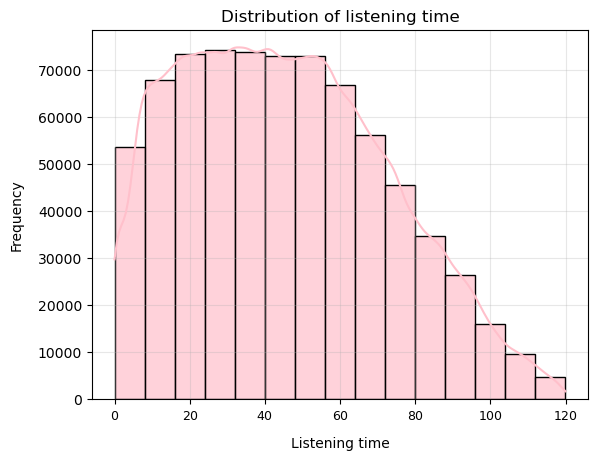

In [216]:
sns.histplot(train['Listening_Time_minutes'], bins=15, alpha=0.7, edgecolor='black', color='pink', kde=True)
plt.xlabel('Listening time', labelpad=10)
plt.ylabel('Frequency', labelpad=10)
plt.xticks(fontsize=9)
plt.title('Distribution of listening time')
plt.grid(True, alpha=0.3)
plt.show()

**Insights:**
- The most popular listening time is around 20 and 50 minutes. 
- As listening time increases, the frequency gradually declines.
- The KDE is shifted to the left, meaning that users usually don't listen for very long.

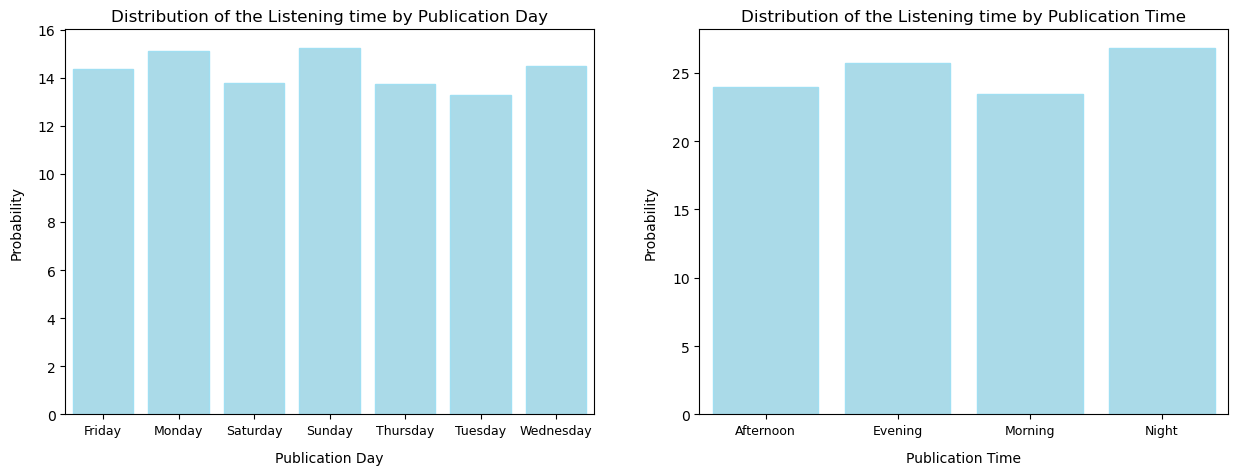

In [217]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
train_listening_publication_day = train.groupby("Publication_Day")['Listening_Time_minutes'].sum()
train_listening_publication_day_prob = train_listening_publication_day / train_listening_publication_day.sum() *100
sns.barplot(x=train_listening_publication_day_prob.index, y=train_listening_publication_day_prob.values, color="#A0DFF2", edgecolor="#A0DFF2")
plt.xlabel('Publication Day', labelpad=10)
plt.ylabel('Probability', labelpad=10)
plt.xticks(fontsize=9)
plt.title('Distribution of the Listening time by Publication Day')

plt.subplot(1, 2, 2)
train_listening_publication_time = train.groupby("Publication_Time")['Listening_Time_minutes'].sum()
train_listening_publication_time_prob = train_listening_publication_time / train_listening_publication_time.sum() * 100
sns.barplot(x=train_listening_publication_time_prob.index, y=train_listening_publication_time_prob.values, color="#A0DFF2", edgecolor="#A0DFF2")
plt.xlabel('Publication Time', labelpad=10)
plt.ylabel('Probability', labelpad=10)
plt.xticks(fontsize=9)
plt.title('Distribution of the Listening time by Publication Time')
plt.show()

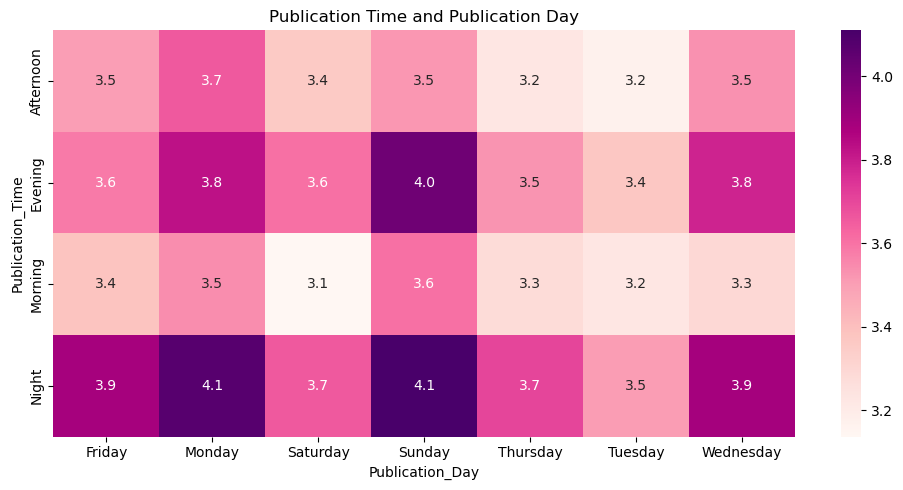

In [218]:
plt.figure(figsize=(10, 5))
cross_tab = pd.crosstab(train['Publication_Time'], train['Publication_Day'], aggfunc='sum', values=train['Listening_Time_minutes'], normalize=True)
sns.heatmap(cross_tab * 100, annot=True, fmt=".1f", cmap='RdPu')
plt.title("Publication Time and Publication Day")
plt.tight_layout()
plt.show()

**Insights:**
1. There are no significant differences and dependences between the distributions by specific days of the week and publication times, but the highest values ​​are observed on Mondays and Sundays, as well as at night and in the evening.
2. The most active time is Sunday Nights and Evenings and Moday Nights.

In [219]:
selected_features = ['Episode_Length_minutes', 'Host_Popularity_percentage', 
                     'Guest_Popularity_percentage', 'Number_of_Ads', 'Listening_Time_minutes']

<Figure size 2500x2500 with 0 Axes>

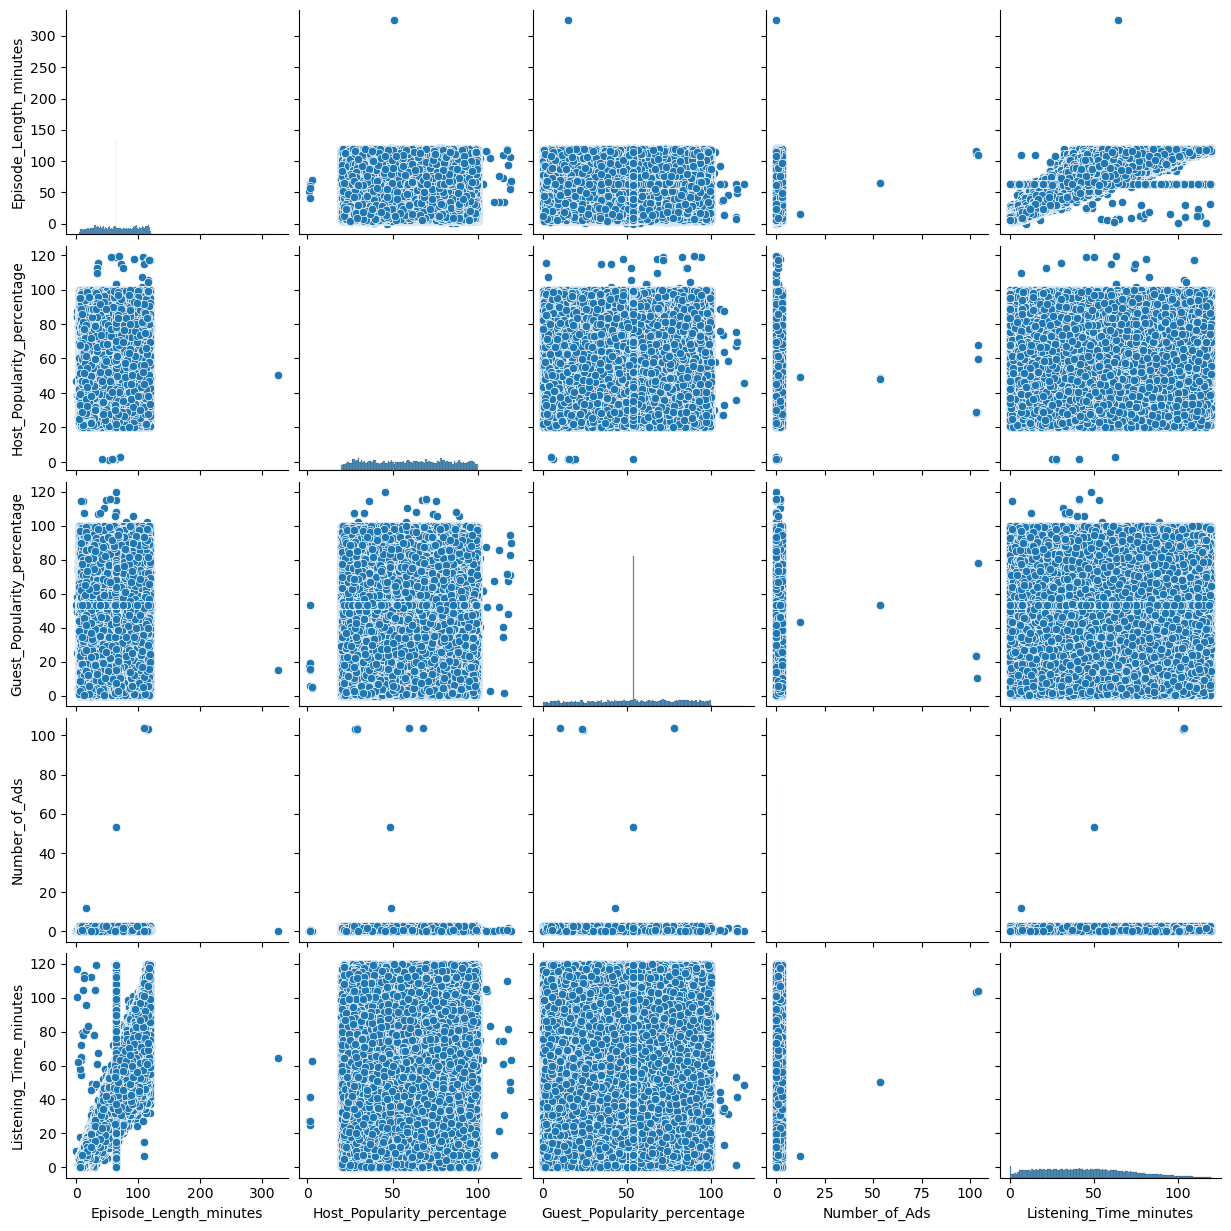

In [220]:
plt.figure(figsize=(25,25))
sns.pairplot(train[selected_features])
plt.show()

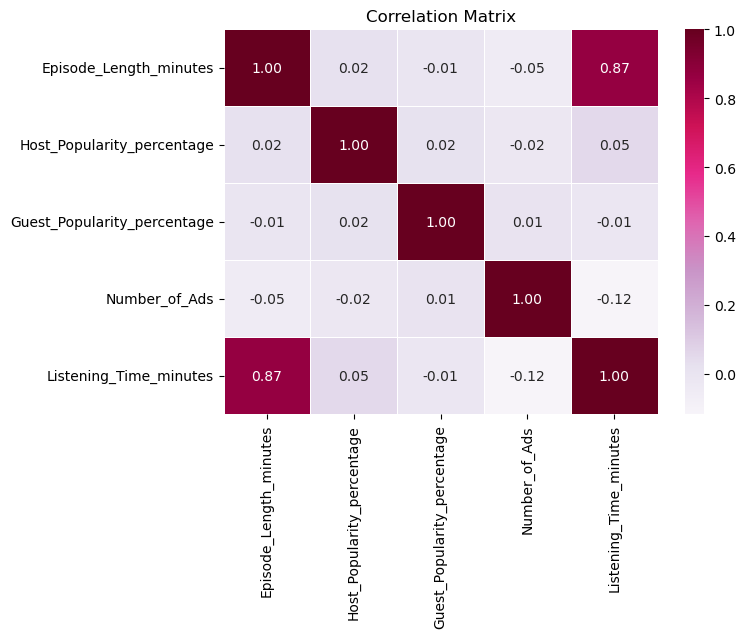

In [221]:
corr_matrix = train[selected_features].corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr_matrix, annot=True, cmap="PuRd", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

**Insights:**
- There is a strong positive correlation between `Episode_Length_minutes` and `Listening_Time_minutes` (0.87)
- Between `Number_of_Ads` and `Listening_Time_minutes` there is a negative correlation (-0.12)
- Other variables have correlations with `Listening_Time_minutes` approximately 0

**5.Feature Scaling**
--

**As there are big outliers in the test data so I will use RobustScaler**

In [222]:
X_train = train[num_without_id]
X_test = test[num_without_id]

In [223]:
scaler = RobustScaler()
X_train_scaled=scaler.fit_transform(X_train)
train[num_without_id]=pd.DataFrame(data=X_train_scaled, columns=X_train.columns, index=X_train.index)

In [224]:
train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,0.000000,True Crime,0.367896,Thursday,Night,0.000000,-0.5,Positive,31.41998
1,1,Joke Junction,Episode 26,1.101002,Comedy,0.171984,Saturday,Afternoon,0.612497,0.5,Negative,88.01241
2,2,Study Sessions,Episode 16,0.199057,Education,0.247258,Tuesday,Evening,-1.223075,-0.5,Negative,44.92531
3,3,Digital Digest,Episode 45,0.066811,Technology,-0.070538,Monday,Morning,0.687860,0.5,Positive,46.27824
4,4,Mind & Body,Episode 86,0.918452,Health,0.499003,Monday,Afternoon,0.139216,1.0,Neutral,75.61031


In [225]:
X_test_scaled = scaler.transform(X_test)
test[num_without_id] = pd.DataFrame(data=X_test_scaled, columns=X_test.columns, index=X_test.index)
test.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,0.298487,Education,-0.546859,Saturday,Evening,-0.007399,0.0,Neutral
1,750001,Sound Waves,Episode 23,-0.705443,Music,0.280160,Sunday,Morning,0.000000,-0.5,Neutral
2,750002,Joke Junction,Episode 11,0.104736,Comedy,0.195414,Friday,Evening,1.203343,-0.5,Positive
3,750003,Comedy Corner,Episode 73,1.014345,Comedy,-0.913509,Sunday,Morning,-0.050699,0.5,Positive
4,750004,Life Lessons,Episode 50,0.168009,Lifestyle,-0.048604,Wednesday,Morning,-1.159222,0.5,Neutral


**6. Data Visualization**
--

**Detect Outliers (3-Sigma Technique)**

In [227]:
def find_anomalies(data):
    anomalies=[]
    data_std = statistics.stdev(data)
    data_mean = statistics.mean(data)
    anomaly_cut_off = data_std * 3
    lower_limit = data_mean - anomaly_cut_off
    upper_limit = data_mean +anomaly_cut_off
    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies

In [ ]:
def list_outliers(data, columns):
    anomalies = []
    for col in columns:
        outliers = find_anomalies(data[col])
        print(f"In the {col} column there are {len(outliers)} outliers")
        anomalies.append((col, outliers))
    return anomalies

In [240]:
print("Train outliers:")
train_anomalies = list_outliers(train, num_without_id)
print("Test outliers:")
test_anomalies = list_outliers(test, num_without_id)

Train outliers:
In the Episode_Length_minutes column there are 1 outliers
In the Host_Popularity_percentage column there are 0 outliers
In the Guest_Popularity_percentage column there are 0 outliers
In the Number_of_Ads column there are 9 outliers
Test outliers:
In the Episode_Length_minutes column there are 1 outliers
In the Host_Popularity_percentage column there are 0 outliers
In the Guest_Popularity_percentage column there are 0 outliers
In the Number_of_Ads column there are 2 outliers


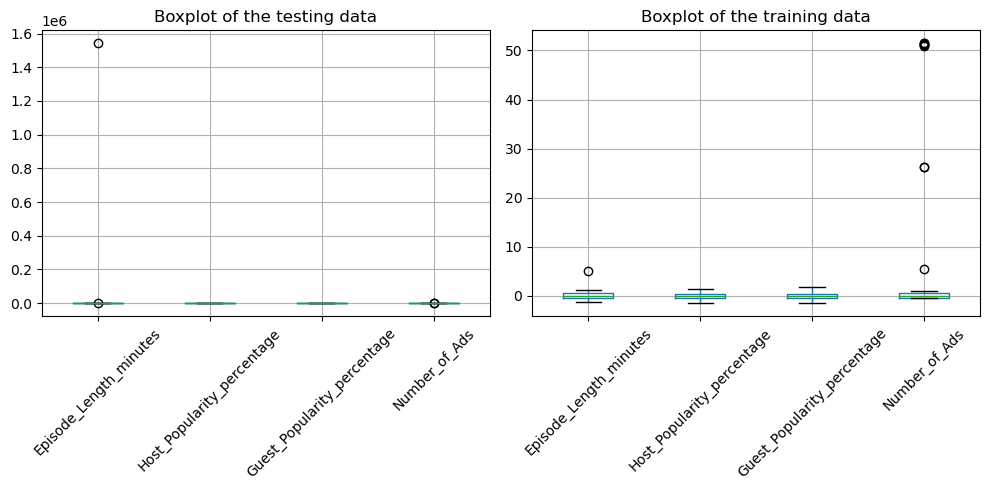

In [272]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
test[num_without_id].boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot of the testing data")
plt.subplot(1,2,2)
train[num_without_id].boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot of the training data")
plt.tight_layout()
plt.show()

In [ ]:
def skewed(data, columns):
    for col in columns:
        print(f"The skewness of the {col} is {data[col].skew()}")

In [248]:
print('Training data')
skewed(train, num_without_id)
print('Testing data')
skewed(test, num_without_id)

Training data
The skew of the Episode_Length_minutes is 0.006122988519005
The skew of the Host_Popularity_percentage is 0.004926275346944309
The skew of the Guest_Popularity_percentage is -0.15035556262425495
The skew of the Number_of_Ads is 6.032995851780484
Testing data
The skew of the Episode_Length_minutes is 499.99996387729857
The skew of the Host_Popularity_percentage is 0.011749553531102417
The skew of the Guest_Popularity_percentage is -0.14875420913689408
The skew of the Number_of_Ads is 448.86746290951714


[]

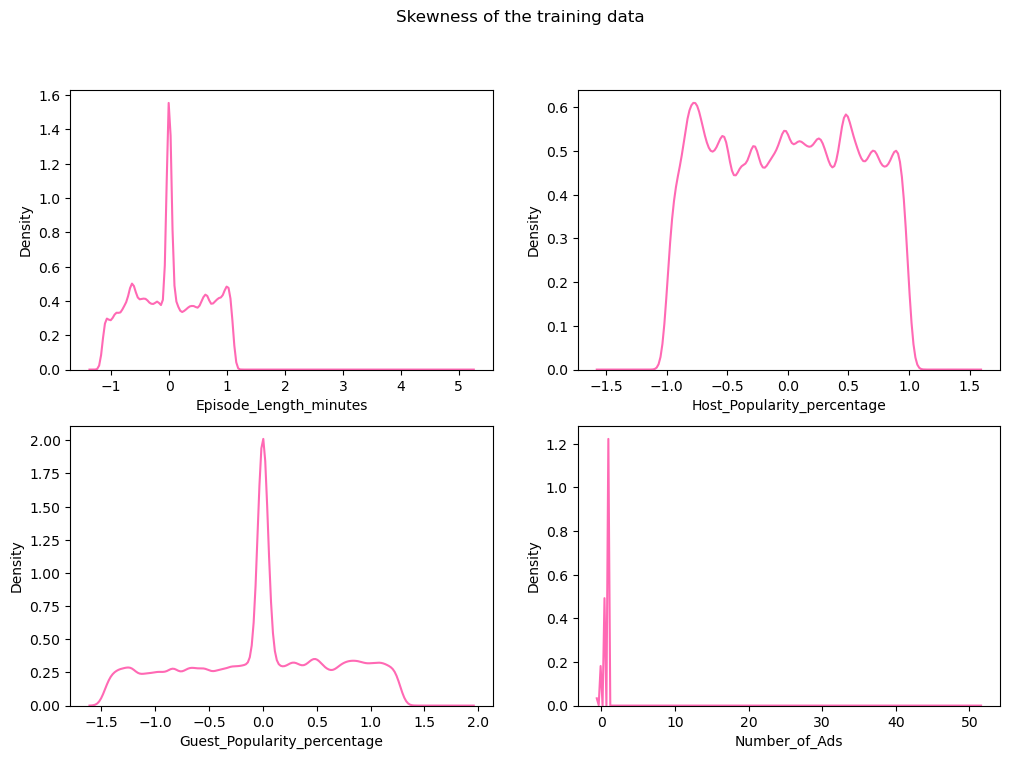

In [261]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
sns.kdeplot(train['Episode_Length_minutes'], ax=axes[0, 0], color='hotpink')
sns.kdeplot(train['Host_Popularity_percentage'], ax=axes[0, 1], color='hotpink')
sns.kdeplot(train['Guest_Popularity_percentage'], ax=axes[1, 0], color='hotpink')
sns.kdeplot(train['Number_of_Ads'], ax=axes[1, 1], color='hotpink')
fig.suptitle("Skewness of the training data")
plt.plot()

[]

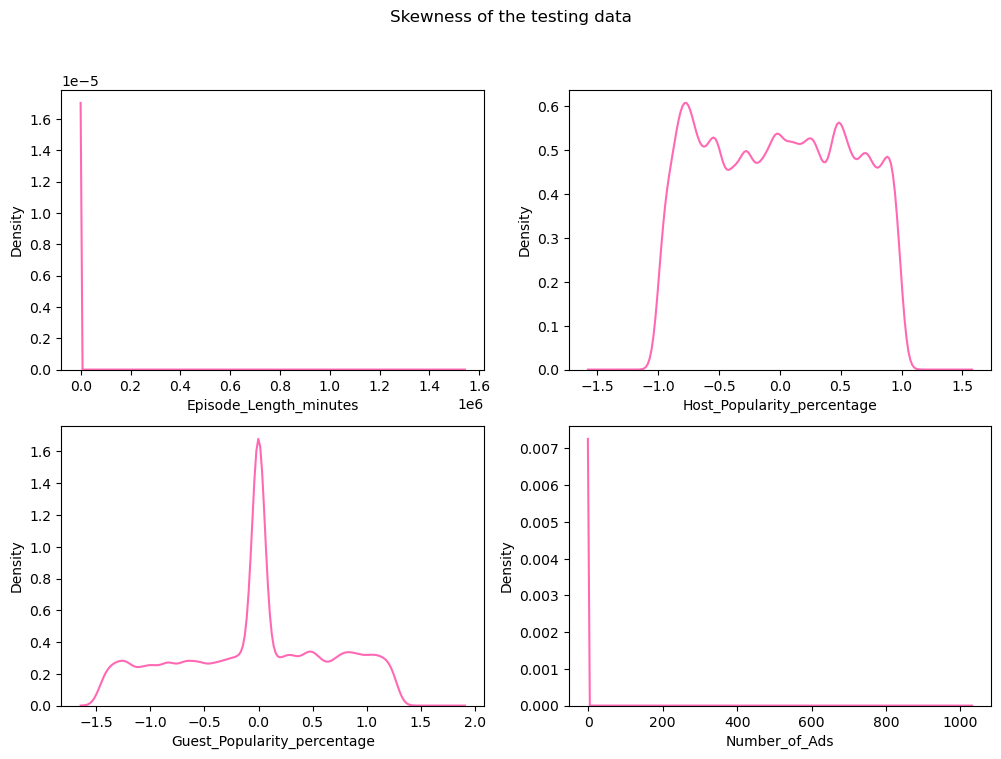

In [260]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
sns.kdeplot(test['Episode_Length_minutes'], ax=axes[0, 0], color='hotpink')
sns.kdeplot(test['Host_Popularity_percentage'], ax=axes[0, 1], color='hotpink')
sns.kdeplot(test['Guest_Popularity_percentage'], ax=axes[1, 0], color='hotpink')
sns.kdeplot(test['Number_of_Ads'], ax=axes[1, 1], color='hotpink')
fig.suptitle("Skewness of the testing data")
plt.plot()

**Insights:**
1. There is no such a big amount of outliers, but they are big
2. The `Guest_Popularity_percentage` and the `Host_Popularity_percentage` columns have very similar skewness both in training and testing data, they are close to the normal distribution
3. `Number_of_Abs` column is right-skewed in both data sets, but the testing set has much higher value of skew then the training set
4. `Episode_Length_minutes` is right-skewed in the testing data and has huge value of skew, but in the training data this column is close to the normal distribution

**7. General Observations and Summary**
--